# Additional Evaluation

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, \
    accuracy_score, recall_score, precision_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
plt.rcParams["font.family"] = "STIXGeneral"

# Overview
In the previous section, we found that using a soft voting classifier to predict 2012 survey respondents as voters and non-voters yielded the best results with an F1-score of **0.611**. However, the F1-score may not actually be the best metric with which to measure the performance of a model. During [exploratory data analysis](https://github.com/zhao1701/Springboard-Capstone-I/blob/master/03%20Exploratory%20Data%20Analysis.ipynb), we observed that voter turnout for presidential election years on or after 2000 never dipped below 70% and sometimes came close to 80%. Given that the sample universe of the ANES surveys is that of eligible voters (adults who may vote if they register), these turnout numbers are highly suspect. Turnout data from the [United States Election Project](http://www.fairvote.org/voter_turnout#voter_turnout_101) (USEP), regarded by many as among the most accurate available suggests that voter turnout to be around 60% for those election years.

In [2]:
anes_turnout = np.array([.723, .766, .776, .778])
usep_turnout = np.array([.542, .601, .606, .586])
difference = anes_turnout - usep_turnout

table = np.concatenate([anes_turnout, usep_turnout, difference], axis = 0).reshape(3,4).T
table = pd.DataFrame(table, columns = ['ANES','USEP','ANES - USEP'],
                     index = ['2000','2004','2008','2012'])
table

,ANES,USEP,ANES - USEP
2000,0.723,0.542,0.181
2004,0.766,0.601,0.165
2008,0.776,0.606,0.170
2012,0.778,0.586,0.192


If turnout data from USEP is to be believed, this means that anywhere from 16% to 20% of respondents from each year of ANES survey may have claimed to have voted despite not actually voting, a classic case of [social desirability bias](https://en.wikipedia.org/wiki/Social_desirability_bias). This also suggests that the ground truth of the ANES survey is unreliable and may explain why classification models do not perform better than they do when measured with this ground truth.

# A different approach to evaluation
Although the ground truth of the ANES survey may be unreliable, it is only so for one class of categories. That is, one expects a respondent claiming to have voted despite doing no such thing to be far more common than a respondent claiming to have not voted despite actually voting. Thus, one can assume the ground truth for those respondents labelled as non-voters to be reliable even if the same cannot be said for those labelled as voters.

Given that the ground truth of the voting behavior of ANES survey respondents may be problematic, the F1-score may not be the best means of evaluating a model. If in fact, the whole point of predicting whether or not a respondent will vote is to aid in obtaining a more accurate picture of how a race stands, a better measure of a model's effectiveness is whether or not it can reduce the error of a survey-based prediciton of a presidential election's popular vote results relative to the official popular vote of that election.

### Survey-based prediction
First, we obtain a survey-based prediction of the popular vote result for the target year. This prediction is relatively straightforward - we use the feature *VCF0713*, which records the respondent's vote intention (who the respondent intends to vote for, including not voting), and apply the sampling weights assigned for each respondent to make an inference about what the popular vote result might be.

Let $w$ and $v$ be the sampling weight and vote intention of a respondent, respectively. Then $w_i$ and $v_i$ denote the sampling weight and vote intention of the $i^{th}$ respondent, respectively. Let $n \in v$ represent the intention of the respondent not to vote. Then $P_j$, the proportion of voting respondents who voted for candidate $j$, as predicted using only survey data, can be defined:

$P_j = \dfrac{\sum_{i=1}^m w_i \delta_{v_ij}}{\sum_{i=1}^m w_i (1 - \delta_{v_in})}$ where 
$ \begin{equation}
  \delta_{v_ij} = \begin{cases}
    0, & \text{if $v_i \neq j$}.\\
    1, & \text{if $v_i = j$}.
  \end{cases}
\end{equation}$.

### Model-based prediction
Obtaining a model-based prediction involves more steps. Let a non-voter be considered a positive case in the context of classification, and a voter be considered a negative case. Because we are assuming that many respondents claimed to have voted despite not voting while few respondents claimed to have not voted despite voting, we have a high tolerance for a model that produces many false positives but a low tolerance for one that produces many false negatives. In other words, we want to rig the algorithm-based model to classify as many true positives (accurately predicted non-voters) as it can even if it means the model might produce many false positives (voters misclassified as non-voters) because the false positives may likely be those respondents who claimed to have voted but did not actually.

Concretely, this means we seek a model with a high [recall](https://en.wikipedia.org/wiki/Precision_and_recall), which can be obtained by lowering the threshold for a positive classification. That is, if the probability that a respondent is a non-voter (as determined by the model's algorithm) is above a certain threshold, that respondent will be classified as a non-voter. Thus, a lower threshold means more respondents will be classified as non-voters, resulting in an increase in both true and false positives.

Thus, in order to rig the model properly, we need to find a threshold that enables the model to classify with a recall of **0.8**. The recall value of **0.8** is admittedly arbitrary and based on a gut instinct; asking a model to correctly classify all positive cases (resulting in a recall of **1.0**) may require a threshold so low as to be meaningless, yet a model with too low a recall may not have an inclusive enough picture of what a potential non-voter may look like. However, we address the issue of this arbitrariness by examining the effects of different values for recall at the end of this notebook.

After training a model on all data from elections prior to the target year and finding a threshold so that the model can make predictions on the training data with a recall of **0.8**, we then apply the model to data from the target year. Combining the model's predictions as to which respondents are voters and non-voters with information about which candidate the respondent plans to support, we can make a modified prediction about the target year's popular vote results.

Let $w$ be the sampling weight, $v$ be the vote intention, and $z \in \{0, 1\}$ be the model-generated non-vote/vote prediction of a respondent, where $1$ indicates a predicted vote. Then $w_i$, $v_i$, and $z_i$ denote those properties of the $i^{th}$ respondent, and $P'_j$, the proportion of voting respondents who voted for candidate $j$, as predicted using an algorithm-based model, can be defined:

$P'_j = \dfrac{\sum_{i=1}^m w_i \delta_{v_ij} z_i}{\sum_{i=1}^m w_i z_i}$ where 
$ \begin{equation}
  \delta_{v_ij} = \begin{cases}
    0, & \text{if $v_i \neq j$}.\\
    1, & \text{if $v_i = j$}.
  \end{cases}
\end{equation}$.

# Load data
In the previous section, we used a soft voting classifier to make and save prediction probabilities about whether respondents from a target year were voters or non-voters. In addition to the probabilities for the target year, we also saved predicition probabilities generated on the training data, as these will be necessary to find an appropriate threshold that yields a recall of **0.8**. Because we are evaluating the model on three target years, 2004, 2008, and 2012, we will need three sets of training and test prediction probabilities.

In [3]:
df_orig = pd.read_csv('../data/anes_cdf_converted.csv').drop(['Unnamed: 0','congressional_district','state'], axis = 1)
with open('../data/predictions_train_2012.pkl','rb') as f:
    predictions_train = pkl.load(f)
with open('../data/predictions_test_2012.pkl','rb') as f:
    predictions_test = pkl.load(f)  
final_vote_df = df_orig.loc[:,['year','weight','VCF0713_oh1','VCF0713_oh2','VCF0713_oh3','VCF0713_oh4', 
                               'VCF0713_oh5','final_vote']]
predictions = np.append(predictions_train, predictions_test, axis = 0)
final_vote_df = pd.concat([final_vote_df, pd.DataFrame(predictions)], axis = 1)

In [4]:
with open('../data/predictions_train_2008b.pkl','rb') as f:
    predictions_train = pkl.load(f)
with open('../data/predictions_test_2008b.pkl','rb') as f:
    predictions_test = pkl.load(f)
predictions = np.append(predictions_train, predictions_test, axis = 0)
final_vote_df = pd.concat([final_vote_df, pd.DataFrame(predictions)], axis = 1)

In [5]:
with open('../data/predictions_train_2004b.pkl','rb') as f:
    predictions_train = pkl.load(f)
with open('../data/predictions_test_2004b.pkl','rb') as f:
    predictions_test = pkl.load(f)
predictions = np.append(predictions_train, predictions_test, axis = 0)
final_vote_df = pd.concat([final_vote_df, pd.DataFrame(predictions)], axis = 1)
final_vote_df.columns = ['year','weight','intend_dem','intend_rep','intend_un','intend_not',
                        'intend_other','final_vote','prediction_2012','prediction_2008','prediction_2004']

In [44]:
def evaluate(y, y_pred, threshold):
    y_pred = y_pred > threshold
    print('Accuracy:', accuracy_score(y, y_pred))
    print('Precision:', precision_score(y, y_pred))
    print('Recall:', recall_score(y, y_pred))
    print('F1 score:', f1_score(y, y_pred))
    print('Confusion matrix:\n', confusion_matrix(y, y_pred))
    print('Predicted proportion non-voters:', sum(y_pred) / len(y_pred))

In [71]:
def threshold_vs_recall(y, y_pred, target_recall = 0.8, thresholds = np.arange(0, 1.01, .01), plot = False):
    recall_list = []
    target_threshold = 0
    for threshold in thresholds:
        score = recall_score(y, y_pred > threshold)
        recall_list.append(score)
        if target_threshold == 0 and score <= target_recall:
            target_threshold = threshold
    if plot:
        plt.figure(figsize = (4,3))
        plt.plot(thresholds, recall_list)
        plt.xlabel('Threshold')
        plt.ylabel('Recall')
        plt.title('Threshold vs. Recall')
        plt.show()
    return target_threshold

# 2004
We first treat 2004 as the target year and evaluate the error of a survey-based prediction relative to the actual popular vote results from the 2004 presidential election.

In [139]:
dem_test_pre = sum(final_vote_df.weight[(final_vote_df.intend_dem == 1) & (final_vote_df.year == 2004)])
rep_test_pre = sum(final_vote_df.weight[(final_vote_df.intend_rep == 1) & (final_vote_df.year == 2004)])
un_test_pre = sum(final_vote_df.weight[(final_vote_df.intend_un == 1) & (final_vote_df.year == 2004)])
other_test_pre = sum(final_vote_df.weight[(final_vote_df.intend_other == 1) & (final_vote_df.year == 2004)])

pre_election = np.array([dem_test_pre, rep_test_pre, other_test_pre])
pre_election = pre_election / pre_election.sum()

y_train = final_vote_df.final_vote[final_vote_df.year < 2004] == 0
y_train_pred = final_vote_df.prediction_2004[final_vote_df.year < 2004]

results = np.array([.483, .507, .01])
data = pd.DataFrame(np.append(results.reshape(-1,3), pre_election.reshape(-1,3), axis = 0).T,
                    columns = ['Actual', 'Survey'],
                    index = ['Democrat','Republican','Other'])

data_print = data[:]
data_print.loc[:,'Error'] = data_print.loc[:,'Survey'] - data_print.loc[:,'Actual']
print(data_print)

            Actual    Survey     Error
Democrat     0.483  0.493902  0.010902
Republican   0.507  0.485032 -0.021968
Other        0.010  0.021066  0.011066


While the survey-based prediction error is not egregious, with the largest error being only a 2.2% difference from the actual popular vote proportion for republicans, the error would have resulted in a prediction showing John Kerry, the democratic candidate, ahead of republican incumbent George W. Bush. It appears that using respondents' self-reporting regarding their intent to vote and who they plan to vote for results in over-estimating support for the democratic and third party candidates while underestimating support for the republican candidate.

Next, we search for the appropriate threshold that will result in training data being predicted with a recall of **0.8**.

In [140]:
y_train = final_vote_df.final_vote[final_vote_df.year < 2004] == 0
y_train_pred = final_vote_df.prediction_2004[final_vote_df.year < 2004]
x = threshold_vs_recall(y_train, y_train_pred)
print('Threshold for recall of 0.8:', x)

Threshold for recall of 0.8: 0.13


In [141]:
evaluate(y_train, y_train_pred, x)

Accuracy: 0.853760445682
Precision: 0.717488789238
Recall: 0.792079207921
F1 score: 0.752941176471
Confusion matrix:
 [[453  63]
 [ 42 160]]
Predicted proportion non-voters: 0.310584958217


A non-voter prediction threshold of **0.32** is required to achieve a recall of **0.8** on the training data, which consists only of respondents from 2000. Such a threshold results in a slightly greater number false positives (claimed voters classified as non-voters) than false negatives (non-voters classified as voters).

After training a soft voting classifier on data from 2000, we use the model to predict who will or will not vote in the 2004 elections. With this data, we can construct a model-based forecast of the popular vote results for 2004.

In [142]:
threshold = x
dem_test_pred = sum(final_vote_df.weight[(final_vote_df.intend_dem == 1) & (final_vote_df.year == 2004)
                                        & ~(final_vote_df.prediction_2004 > threshold)])
rep_test_pred = sum(final_vote_df.weight[(final_vote_df.intend_rep == 1) & (final_vote_df.year == 2004)
                                        & ~(final_vote_df.prediction_2004 > threshold)])
un_test_pred = sum(final_vote_df.weight[(final_vote_df.intend_un == 1) & (final_vote_df.year == 2004)
                                       & ~(final_vote_df.prediction_2004 > threshold)])
other_test_pred = sum(final_vote_df.weight[(final_vote_df.intend_other == 1) & (final_vote_df.year == 2004)
                                          & ~(final_vote_df.prediction_2004 > threshold)])

pred_election = np.array([dem_test_pred, rep_test_pred, other_test_pred])
pred_election = pred_election / pred_election.sum()

results = np.array([.483, .507, .01])
data = pd.DataFrame(np.concatenate([results.reshape(-1,3), pre_election.reshape(-1,3), pred_election.reshape(-1,3)],
                                   axis = 0).T, columns = ['Actual', 'Survey', 'Model'],
                    index = ['Democrat','Republican','Other'])

data_print = data[:]
data_print.loc[:,'Survey Error'] = data_print.loc[:,'Survey'] - data_print.loc[:,'Actual']
data_print.loc[:,'Model Error'] = data_print.loc[:,'Model'] - data_print.loc[:,'Actual']
print(data_print)

fig, axes = plt.subplots(3, 2, figsize = (10,9))
data.plot(kind = 'bar', ax = axes[0][0], color = ['black','silver','steelblue'],
          title = '2004 Election: actual vs predicted results')
axes[0][0].set_ylabel('Proportion of vote')

data_print.loc[:,['Survey Error','Model Error']].plot(kind = 'bar', ax = axes[0][1], color = ['silver','steelblue'])
axes[0][1].axhline(0, color = 'black')
axes[0][1].set_title('2004 survey and model prediction error')

            Actual    Survey     Model  Survey Error  Model Error
Democrat     0.483  0.493902  0.486360      0.010902     0.003360
Republican   0.507  0.485032  0.496353     -0.021968    -0.010647
Other        0.010  0.021066  0.017286      0.011066     0.007286


From the data above, we see that using a classification model, even an imperfect one, to determine whether or not a respondent will actually vote yields substantially better results than simply taking respondents at their word. For all three candidate categories, using the model's non-vote classifications results in a prediction closer to the election result. More importantly, whereas the survey-based prediction incorrectly shows John Kerry ahead of George W. Bush (albeit by a razor-thin margin), the model-based prediction shows George W. Bush leading, which is in line with the actual 2004 results.

Finally, we take a look at how the model performed relative to the ground truth of the survey itself.

In [143]:
y_test = final_vote_df.final_vote[final_vote_df.year == 2004] == 0
y_test_pred = final_vote_df.prediction_2004[final_vote_df.year == 2004]
evaluate(y_test, y_test_pred, x)

Accuracy: 0.805816135084
Precision: 0.575342465753
Recall: 0.669322709163
F1 score: 0.618784530387
Confusion matrix:
 [[691 124]
 [ 83 168]]
Predicted proportion non-voters: 0.27392120075


Applying a non-voter prediction threshold of **0.32** to respondents from the target year, 2004, results in a recall of **0.69** and a situation similar to the training predictions where false positives slightly outnumber false negatives.

In [144]:
table_2004 = data

# 2008
We now treat 2008 as the target year and evaluate the error of a survey-based prediction relative to the actual popular vote results from the 2008 presidential election.

In [145]:
dem_test_pre = sum(final_vote_df.weight[(final_vote_df.intend_dem == 1) & (final_vote_df.year == 2008)])
rep_test_pre = sum(final_vote_df.weight[(final_vote_df.intend_rep == 1) & (final_vote_df.year == 2008)])
un_test_pre = sum(final_vote_df.weight[(final_vote_df.intend_un == 1) & (final_vote_df.year == 2008)])
other_test_pre = sum(final_vote_df.weight[(final_vote_df.intend_other == 1) & (final_vote_df.year == 2008)])

pre_election = np.array([dem_test_pre, rep_test_pre, other_test_pre])
pre_election = pre_election / pre_election.sum()

results = np.array([.529, .457, .014])
data = pd.DataFrame(np.append(results.reshape(-1,3), pre_election.reshape(-1,3), axis = 0).T,
                    columns = ['Actual', 'Survey'],
                    index = ['Democrat','Republican','Other'])

data_print = data[:]
data_print.loc[:,'Error'] = data_print.loc[:,'Survey'] - data_print.loc[:,'Actual']
print(data_print)

            Actual    Survey     Error
Democrat     0.529  0.540786  0.011786
Republican   0.457  0.432473 -0.024527
Other        0.014  0.026741  0.012741


Interestingly, the survey error for 2008 follows a similar pattern to that of 2004, overestimating the democratic and third party share of the popular vote while underestimating the republican share.

Next, we search for the appropriate threshold that will result in training data from before the target year 2008 being predicted with a recall of **0.8**.

In [146]:
y_train = final_vote_df.final_vote[final_vote_df.year < 2008] == 0
y_train_pred = final_vote_df.prediction_2008[final_vote_df.year < 2008]
x = threshold_vs_recall(y_train, y_train_pred)
print('Threshold for recall of 0.8:', x)

Threshold for recall of 0.8: 0.32


In [147]:
evaluate(y_train, y_train_pred, x)

Accuracy: 0.848094170404
Precision: 0.668518518519
Recall: 0.796909492274
F1 score: 0.727089627392
Confusion matrix:
 [[1152  179]
 [  92  361]]
Predicted proportion non-voters: 0.30269058296


A non-voter prediction threshold of **0.31** is required to achieve a recall of **0.8** on the training data, which consists only of respondents from 2000 and 2004. While the threshold of **0.31** is quite close to the **0.32** threshold used for predicting 2004 votes, notice that for this set of training data, achieving the required recall results in far more false positive relative to false negatives.

After training a soft voting classifier on data from 2000 and 2004, we use the model to predict who will or will not vote in the 2008 elections. With this data, we can construct a model-based forecast of the popular vote results for 2008.

In [148]:
threshold = x
dem_test_pred = sum(final_vote_df.weight[(final_vote_df.intend_dem == 1) & (final_vote_df.year == 2008)
                                        & ~(final_vote_df.prediction_2008 > threshold)])
rep_test_pred = sum(final_vote_df.weight[(final_vote_df.intend_rep == 1) & (final_vote_df.year == 2008)
                                        & ~(final_vote_df.prediction_2008 > threshold)])
un_test_pred = sum(final_vote_df.weight[(final_vote_df.intend_un == 1) & (final_vote_df.year == 2008)
                                       & ~(final_vote_df.prediction_2008 > threshold)])
other_test_pred = sum(final_vote_df.weight[(final_vote_df.intend_other == 1) & (final_vote_df.year == 2008)
                                          & ~(final_vote_df.prediction_2008 > threshold)])

pred_election = np.array([dem_test_pred, rep_test_pred, other_test_pred])
pred_election = pred_election / pred_election.sum()

results = np.array([.529, .457, .014])
data = pd.DataFrame(np.concatenate([results.reshape(-1,3), pre_election.reshape(-1,3), pred_election.reshape(-1,3)],
                                   axis = 0).T, columns = ['Actual', 'Survey', 'Model'],
                    index = ['Democrat','Republican','Other'])

data_print = data[:]
data_print.loc[:,'Survey Error'] = data_print.loc[:,'Survey'] - data_print.loc[:,'Actual']
data_print.loc[:,'Model Error'] = data_print.loc[:,'Model'] - data_print.loc[:,'Actual']
print(data_print)

data.plot(kind = 'bar', ax = axes[1][0], color = ['black','silver','steelblue'],
          title = '2008 Election: actual vs predicted results')
axes[1][0].set_ylabel('Proportion of vote')

data_print.loc[:,['Survey Error','Model Error']].plot(kind = 'bar', ax = axes[1][1], color = ['silver','steelblue'])
axes[1][1].axhline(0, color = 'black')
axes[1][1].set_title('2008 survey and algorithm prediction error')

            Actual    Survey     Model  Survey Error  Model Error
Democrat     0.529  0.540786  0.536188      0.011786     0.007188
Republican   0.457  0.432473  0.446557     -0.024527    -0.010443
Other        0.014  0.026741  0.017255      0.012741     0.003255


From the data above, we see that, once again, using a classification model, to determine whether or not a respondent will actually vote yields substantially better results than using a survey-based prediction. Like before, for all three candidate categories, using the model's non-vote classifications results in a prediction closer to the election result. In fact, the model trained on 2000 and 2004 data to predict the 2008 popular vote behaves quite similarly to the previous model, which was trained on 2000 data to predict the 2004 popular vote. In both cases, the model tends to over-correct the survey error for the democratic candidate, underestimating the actual democratic share of the vote, while providing an improved prediction for third party candidates and a near perfect prediction for the republican share of the vote.

Finally, we take a look at how the model performed relative to the ground truth of the survey itself.

In [149]:
y_test = final_vote_df.final_vote[final_vote_df.year == 2008] == 0
y_test_pred = final_vote_df.prediction_2008[final_vote_df.year == 2008]
evaluate(y_test, y_test_pred, threshold)

Accuracy: 0.761655566127
Precision: 0.538653366584
Recall: 0.767317939609
F1 score: 0.632967032967
Confusion matrix:
 [[1169  370]
 [ 131  432]]
Predicted proportion non-voters: 0.381541389153


Applying a non-voter prediction threshold of **0.31** to respondents from the target year, 2008, results in a recall of **0.72** and a situation similar to the training predictions where false positives outnumber false negatives by **1.7 to 1**.

In [150]:
table_2008 = data

# 2012
We now treat 2012 as the target year and evaluate the error of a survey-based prediction relative to the actual popular vote results from the 2012 presidential election.

In [151]:
dem_test_pre = sum(final_vote_df.weight[(final_vote_df.intend_dem == 1) & (final_vote_df.year == 2012)])
rep_test_pre = sum(final_vote_df.weight[(final_vote_df.intend_rep == 1) & (final_vote_df.year == 2012)])
un_test_pre = sum(final_vote_df.weight[(final_vote_df.intend_un == 1) & (final_vote_df.year == 2012)])
other_test_pre = sum(final_vote_df.weight[(final_vote_df.intend_other == 1) & (final_vote_df.year == 2012)])

pre_election = np.array([dem_test_pre, rep_test_pre, other_test_pre])
pre_election = pre_election / pre_election.sum()

results = np.array([.511, .472, .017])
data = pd.DataFrame(np.append(results.reshape(-1,3), pre_election.reshape(-1,3), axis = 0).T,
                    columns = ['Actual', 'Survey'],
                    index = ['Democrat','Republican','Other'])

data_print = data[:]
data_print.loc[:,'Error'] = data_print.loc[:,'Survey'] - data_print.loc[:,'Actual']
print(data_print)

            Actual    Survey     Error
Democrat     0.511  0.516360  0.005360
Republican   0.472  0.437991 -0.034009
Other        0.017  0.045649  0.028649


The survey error for 2012 follows a similar pattern to that of 2004 and 2008, in that it overestimates the third party share of the popular vote while underestimating the republican share. However, this time, the survey-predicted democratic share is much more accurate than that of past election years.

Next, we search for the appropriate threshold that will result in training data from before the target year 2012 being predicted with a recall of **0.8**.

In [152]:
y_train = final_vote_df.final_vote[final_vote_df.year < 2012] == 0
y_train_pred = final_vote_df.prediction_2012[final_vote_df.year < 2012]
x = threshold_vs_recall(y_train, y_train_pred)
print('Threshold for recall of 0.8:', x)

Threshold for recall of 0.8: 0.29


In [153]:
evaluate(y_train, y_train_pred, x)

Accuracy: 0.839166237777
Precision: 0.660377358491
Recall: 0.792322834646
F1 score: 0.720357941834
Confusion matrix:
 [[2456  414]
 [ 211  805]]
Predicted proportion non-voters: 0.31369016984


A non-voter prediction threshold of **0.29** is required to achieve a recall of **0.8** on the training data, which consists only of respondents from 2000, 2004, and 2008. The threshold of **0.29** is not that far from **0.31** and **0.32** used for previous years, but here it results in almost twice as many false positives as false negatives. 

That the false positive to false negative rate increases with lower thresholds is not surprising in of itself, but the fact that lower thresholds are required to achieve the desired recall rate suggests that the model struggles more on more recent data.

After training a soft voting classifier on data from 2000 and 2004, we use the model to predict who will or will not vote in the 2012 elections. With this data, we can construct a model-based forecast of the popular vote results for 2012.

            Actual    Survey     Model  Survey Error  Model Error
Democrat     0.511  0.516360  0.501206      0.005360    -0.009794
Republican   0.472  0.437991  0.470912     -0.034009    -0.001088
Other        0.017  0.045649  0.027881      0.028649     0.010881


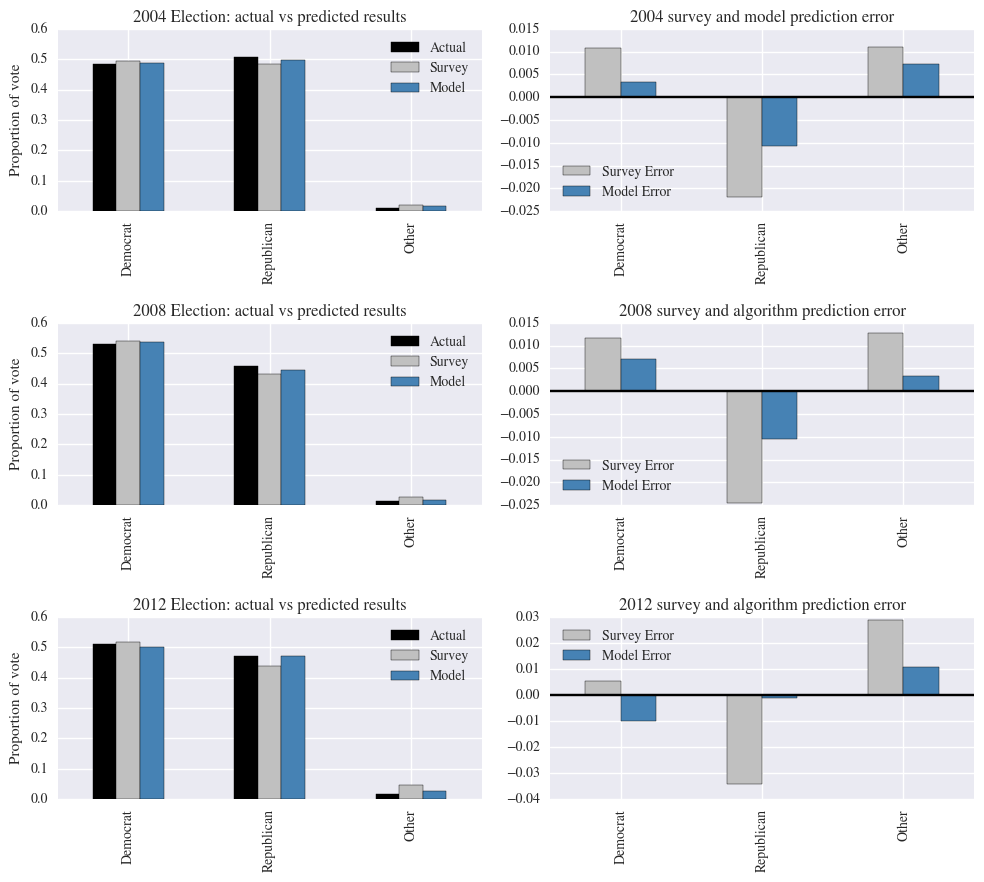

In [154]:
threshold = x
dem_test_pred = sum(final_vote_df.weight[(final_vote_df.intend_dem == 1) & (final_vote_df.year == 2012)
                                        & ~(final_vote_df.prediction_2012 > threshold)])
rep_test_pred = sum(final_vote_df.weight[(final_vote_df.intend_rep == 1) & (final_vote_df.year == 2012)
                                        & ~(final_vote_df.prediction_2012 > threshold)])
un_test_pred = sum(final_vote_df.weight[(final_vote_df.intend_un == 1) & (final_vote_df.year == 2012)
                                       & ~(final_vote_df.prediction_2012 > threshold)])
other_test_pred = sum(final_vote_df.weight[(final_vote_df.intend_other == 1) & (final_vote_df.year == 2012)
                                          & ~(final_vote_df.prediction_2012 > threshold)])

pred_election = np.array([dem_test_pred, rep_test_pred, other_test_pred])
pred_election = pred_election / pred_election.sum()

results = np.array([.511, .472, .017])
data = pd.DataFrame(np.concatenate([results.reshape(-1,3), pre_election.reshape(-1,3), pred_election.reshape(-1,3)],
                                   axis = 0).T, columns = ['Actual', 'Survey', 'Model'],
                    index = ['Democrat','Republican','Other'])

data_print = data[:]
data_print.loc[:,'Survey Error'] = data_print.loc[:,'Survey'] - data_print.loc[:,'Actual']
data_print.loc[:,'Model Error'] = data_print.loc[:,'Model'] - data_print.loc[:,'Actual']
print(data_print)

data.plot(kind = 'bar', ax = axes[2][0], color = ['black','silver','steelblue'],
          title = '2012 Election: actual vs predicted results')
axes[2][0].set_ylabel('Proportion of vote')

data_print.loc[:,['Survey Error','Model Error']].plot(kind = 'bar', ax = axes[2][1], color = ['silver','steelblue'])
axes[2][1].axhline(0, color = 'black')
axes[2][1].set_title('2012 survey and algorithm prediction error')

plt.tight_layout()
plt.show()

Like before, we see that using a classification model to determine whether or not a respondent will actually vote yields better results than using a survey-based prediction. In this case, because the survey-based prediction of the democratic share of the popular vote was quite accurate, the model's behavior actually results in a prediction less accurate than the survey. However, this slightly increase in error for the democratic share of the vote is easily outweighted by the dramatic improvement in predicting both the republican and third party share of the vote.

Finally, we take a look at how the model performed relative to the ground truth of the survey itself.

In [120]:
y_test = final_vote_df.final_vote[final_vote_df.year == 2012] == 0
y_test_pred = final_vote_df.prediction_2012[final_vote_df.year == 2012]
evaluate(y_test, y_test_pred, threshold)

Accuracy: 0.795189504373
Precision: 0.559487492373
Recall: 0.695223654284
F1 score: 0.62001352265
Confusion matrix:
 [[3447  722]
 [ 402  917]]
Predicted proportion non-voters: 0.298651603499


Applying a non-voter prediction threshold of **0.29** to respondents from the target year, 2012, results in a recall of **0.70** and a false positive to false negative ratio of **1.8 to 1**.

In [121]:
table_2012 = data

# Visualizing margins
Oftentimes the margins by which one candidate is ahead of another is of as much interest as the actual vote shares. Below, we plot the difference between democratic and republican proportion of the popular vote, subtracting the republican proportion from the democratic proportion.

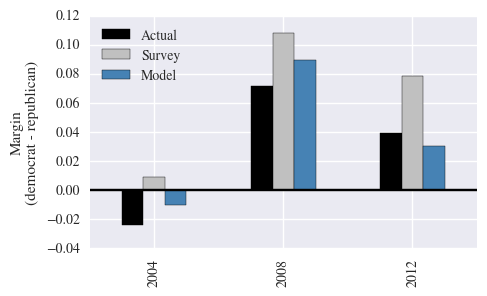

In [157]:
spread_2004 = table_2004.loc['Democrat',:] - table_2004.loc['Republican',:]
spread_2008 = table_2008.loc['Democrat',:] - table_2008.loc['Republican',:]
spread_2012 = table_2012.loc['Democrat',:] - table_2012.loc['Republican',:]
margins = pd.concat([spread_2004, spread_2008, spread_2012], axis = 1)
margins.columns = ['2004','2008','2012']
margins.T.plot(kind = 'bar', color = ['black','silver','steelblue'], figsize = (5,3))
plt.axhline(0, color = 'black')
#plt.title('Comparing margins between survey and model predictions')
plt.ylabel('Margin\n(democrat - republican)')
plt.show()

The model-based predictions of the vote margin are strikingly more accurate than the survey-based predictions. As noted before, the model correctly predicts that George W. Bush would win the popular vote over John Kerry in 2004 when  the survey data alone would have forecasted no such result. In all cases, the survey-based predictions tend to result in overly optimistic projections for democratic candidates, which the models are able to correct.

# Effects of threshold on algorithm predictions
As detailed previously, part of the process for arriving at a model-based prediction for the national popular vote involves setting a non-voter classification threshold so that the recall of the model on training data would equal **0.8**. Ultimately, however reasonable this value may be, it was arbitrarily chosen, so we should examine how changes in the desired training recall affects the model's popular vote predictions.

In [187]:
results = np.array([.483, .507, .01])
dem_test_pred_list = []
rep_test_pred_list = []
un_test_pred_list = []
other_test_pred_list = []
recall_list = []
y_train = final_vote_df.final_vote[final_vote_df.year < 2004] == 0
y_train_pred = final_vote_df.prediction_2004[final_vote_df.year < 2004]
for i in np.arange(.05, 1.001, .001):
    dem = sum(final_vote_df.weight[(final_vote_df.intend_dem == 1) & (final_vote_df.year == 2004) 
                                   & ~(final_vote_df.prediction_2004 > i)])
    rep = sum(final_vote_df.weight[(final_vote_df.intend_rep == 1) & (final_vote_df.year == 2004) 
                                   & ~(final_vote_df.prediction_2004 > i)])
    other = sum(final_vote_df.weight[(final_vote_df.intend_other == 1) & (final_vote_df.year == 2004) 
                                     & ~(final_vote_df.prediction_2004 > i)])
    recall_list.append(recall_score(y_train, y_train_pred > i))
    #print('threshold:',i,'recall:',recall_score(y_train, y_train_pred > i))
    total = dem + rep + other
    if total == 0:
        dem_test_pred_list.append(0)
        rep_test_pred_list.append(0)
        other_test_pred_list.append(0)
    else:
        dem_test_pred_list.append(np.round(dem / total, 3))
        rep_test_pred_list.append(np.round(rep / total, 3))
        other_test_pred_list.append(np.round(other / total, 3))

recall_list = np.array(recall_list)        

indices_dem = [i for i, x in enumerate(dem_test_pred_list) if x == results[0]]
indices_rep = [i for i, x in enumerate(rep_test_pred_list) if x == results[1]]
indices_other = [i for i, x in enumerate(other_test_pred_list) if x == results[2]]   

fig, axes = plt.subplots(1,3, figsize = (10,3))

axes[0].plot(recall_list, dem_test_pred_list, color = 'darkblue')
axes[0].plot(recall_list, rep_test_pred_list, color = 'darkred')
axes[0].plot(recall_list, other_test_pred_list, color = 'darkgoldenrod')
axes[0].scatter(recall_list[indices_dem], [results[0]] * len(indices_dem), marker = 'x',
            s = 100, color = 'blue', linewidth = 2)
axes[0].scatter(recall_list[indices_rep], [results[1]] * len(indices_rep), marker = 'x',
           s = 100, color = 'red', linewidth = 2)
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 0.8)
axes[0].set_title('2004')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Proportion of votes')

A recall of **0.0** corresponds to a threshold of **1.0**. That is, only those respondents for whom the model assigns a non-voting probability of **1.0** are classified as non-voters and thus have their voting intent discounted from the popular vote prediction. Thus, a recall of **0.0** essentially produces the survey-based prediction. It takes a recall of **0.5** and above for the effects of the model to be truly apparent.

We see that while **0.8** is a good value for training recall to predict the 2004 popular vote, the model's predictions are actually quite stable and reasonably accurate for a relatively large range of recall values. From **0.6** to **0.95**, the model would have accurately projected the republican candidate the winner of the popular vote despite survey data suggesting the contrary, and within this range, the model's predictions for the democratic and republican shares of the popular vote never deviates too far from the actual result. In fact, the training recall that would have resulted in a completely accurate prediction for the democratic share of the popular vote is within **0.08** of one of the training recall values that would have accurately predicted the republican share. 

In [188]:
results = np.array([.529, .457, .014])
dem_test_pred_list = []
rep_test_pred_list = []
un_test_pred_list = []
other_test_pred_list = []
recall_list = []
y_train = final_vote_df.final_vote[final_vote_df.year < 2008] == 0
y_train_pred = final_vote_df.prediction_2008[final_vote_df.year < 2008]
for i in np.arange(.15, 1.01, .01):
    dem = sum(final_vote_df.weight[(final_vote_df.intend_dem == 1) & (final_vote_df.year == 2008) 
                                   & ~(final_vote_df.prediction_2008 > i)])
    rep = sum(final_vote_df.weight[(final_vote_df.intend_rep == 1) & (final_vote_df.year == 2008) 
                                   & ~(final_vote_df.prediction_2008 > i)])
    other = sum(final_vote_df.weight[(final_vote_df.intend_other == 1) & (final_vote_df.year == 2008) 
                                     & ~(final_vote_df.prediction_2008 > i)])
    recall_list.append(recall_score(y_train, y_train_pred > i))
    total = dem + rep + other
    if total == 0:
        dem_test_pred_list.append(0)
        rep_test_pred_list.append(0)
        other_test_pred_list.append(0)
    else:
        dem_test_pred_list.append(np.round(dem / total, 3))
        rep_test_pred_list.append(np.round(rep / total, 3))
        other_test_pred_list.append(np.round(other / total, 3))

recall_list = np.array(recall_list)        

indices_dem = [i for i, x in enumerate(dem_test_pred_list) if x == results[0]]
indices_rep = [i for i, x in enumerate(rep_test_pred_list) if x == results[1]]
indices_other = [i for i, x in enumerate(other_test_pred_list) if x == results[2]]   

axes[1].plot(recall_list, dem_test_pred_list, color = 'darkblue')
axes[1].plot(recall_list, rep_test_pred_list, color = 'darkred')
axes[1].plot(recall_list, other_test_pred_list, color = 'darkgoldenrod')
axes[1].scatter(recall_list[indices_dem], [results[0]] * len(indices_dem), marker = 'x',
            s = 100, color = 'blue', linewidth = 2)
axes[1].scatter(recall_list[indices_rep], [results[1]] * len(indices_rep), marker = 'x',
           s = 100, color = 'red', linewidth = 2)
axes[1].scatter(recall_list[indices_other], [results[2]] * len(indices_other), marker = 'x',
           s = 100, color = 'yellow', linewidth = 2)
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 0.8)
axes[1].set_title('2008')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Proportion of votes')

For predicting the 2008 popular vote, a training recall of greater than **0.6** is required for the effects of the model to be visible, higher than the **0.5** training recall for predicting 2004 results. But any training recall from within the range of **0.65** and **0.95** generates an improvement over the survey-based prediction. Once again, a training recall of **0.8** appears to work well, and like before, the recall value necessary for a correct prediction of the democratic share of the vote is quite close, within **0.05**, to that for the republican share.

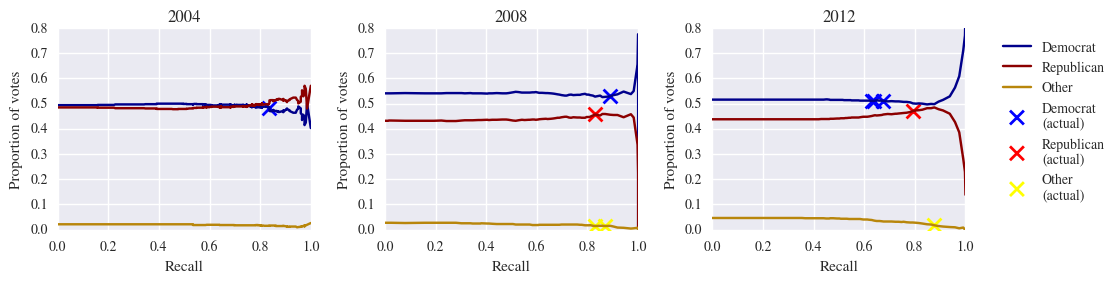

In [189]:
results = np.array([.511, .472, .017])
dem_test_pred_list = []
rep_test_pred_list = []
un_test_pred_list = []
other_test_pred_list = []
recall_list = []
y_train = final_vote_df.final_vote[final_vote_df.year < 2012] == 0
y_train_pred = final_vote_df.prediction_2012[final_vote_df.year < 2012]
for i in np.arange(.15, 1.01, .01):
    dem = sum(final_vote_df.weight[(final_vote_df.intend_dem == 1) & (final_vote_df.year == 2012) 
                                   & ~(final_vote_df.prediction_2012 > i)])
    rep = sum(final_vote_df.weight[(final_vote_df.intend_rep == 1) & (final_vote_df.year == 2012) 
                                   & ~(final_vote_df.prediction_2012 > i)])
    other = sum(final_vote_df.weight[(final_vote_df.intend_other == 1) & (final_vote_df.year == 2012) 
                                     & ~(final_vote_df.prediction_2012 > i)])
    recall_list.append(recall_score(y_train, y_train_pred > i))
    total = dem + rep + other
    if total == 0:
        dem_test_pred_list.append(0)
        rep_test_pred_list.append(0)
        other_test_pred_list.append(0)
    else:
        dem_test_pred_list.append(np.round(dem / total, 3))
        rep_test_pred_list.append(np.round(rep / total, 3))
        other_test_pred_list.append(np.round(other / total, 3))

recall_list = np.array(recall_list)        

indices_dem = [i for i, x in enumerate(dem_test_pred_list) if x == results[0]]
indices_rep = [i for i, x in enumerate(rep_test_pred_list) if x == .471]
indices_other = [i for i, x in enumerate(other_test_pred_list) if x == results[2]]   

axes[2].plot(recall_list, dem_test_pred_list, color = 'darkblue')
axes[2].plot(recall_list, rep_test_pred_list, color = 'darkred')
axes[2].plot(recall_list, other_test_pred_list, color = 'darkgoldenrod')
axes[2].scatter(recall_list[indices_dem], [results[0]] * len(indices_dem), marker = 'x',
            s = 100, color = 'blue', linewidth = 2)
axes[2].scatter(recall_list[indices_rep], [results[1]] * len(indices_rep), marker = 'x',
           s = 100, color = 'red', linewidth = 2)
axes[2].scatter(recall_list[indices_other], [results[2]] * len(indices_other), marker = 'x',
           s = 100, color = 'yellow', linewidth = 2)
axes[2].set_xlim(0, 1)
axes[2].set_ylim(0, 0.8)
axes[2].set_title('2012')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Proportion of votes')
axes[2].legend(['Democrat','Republican','Other','Democrat\n(actual)','Republican\n(actual)',
                'Other\n(actual)'],
           bbox_to_anchor = (1.6,1))
plt.tight_layout()
plt.show()

Of the three election years tested, the model's performance with respect to training recall is least stable for 2012. Whereas the models for previous presidential elections yielded training recall ranges for which the predicted shares for democrats and republicans did not deviate too much, the model for 2012 has no such range. This is partly due to the fact that the most predictive feature in the training data for whether or not a respondent will vote, their vote intention, is much less predictive for the test data, for reasons previously discussed. However, while the difference between the training recall corresponding to an accurate prediction for the democratic share of the vote and that coresponding to an accurate prediction for the republican share of the vote is larger than in previous election years (greater than **0.1**), a training recall of **0.8** still appears to have been a reasonable choice that in fact provides a near-perfect forecast for the republican share of the vote.

Next, we examine how different values for training recall affect the popular vote margins, defined as the republican proportion of the vote subtracted from the democratic share of the vote.

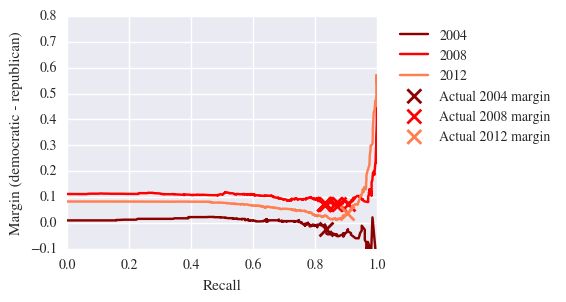

In [191]:
margins_2004 = []
margins_2008 = []
margins_2012 = []
recall_2004 = []
recall_2008 = []
recall_2012 = []

for i in np.arange(.05, 1.001, .001):
    dem = sum(final_vote_df.weight[(final_vote_df.intend_dem == 1) & (final_vote_df.year == 2004) 
                                   & ~(final_vote_df.prediction_2004 > i)])
    rep = sum(final_vote_df.weight[(final_vote_df.intend_rep == 1) & (final_vote_df.year == 2004) 
                                   & ~(final_vote_df.prediction_2004 > i)])
    
    y_train = final_vote_df.final_vote[final_vote_df.year < 2004] == 0
    y_train_pred = final_vote_df.prediction_2004[final_vote_df.year < 2004]
    recall_2004.append(recall_score(y_train, y_train_pred > i))
    margins_2004.append((dem - rep) / (dem + rep))

for i in np.arange(.16, 1.001, .001):
      
    dem = sum(final_vote_df.weight[(final_vote_df.intend_dem == 1) & (final_vote_df.year == 2008) 
                                   & ~(final_vote_df.prediction_2008 > i)])
    rep = sum(final_vote_df.weight[(final_vote_df.intend_rep == 1) & (final_vote_df.year == 2008) 
                                   & ~(final_vote_df.prediction_2008 > i)])
    margins_2008.append((dem - rep) / (dem + rep))
    dem = sum(final_vote_df.weight[(final_vote_df.intend_dem == 1) & (final_vote_df.year == 2012) 
                                   & ~(final_vote_df.prediction_2012 > i)])
    rep = sum(final_vote_df.weight[(final_vote_df.intend_rep == 1) & (final_vote_df.year == 2012) 
                                   & ~(final_vote_df.prediction_2012 > i)])
    margins_2012.append((dem - rep) / (dem + rep))
    
    y_train = final_vote_df.final_vote[final_vote_df.year < 2008] == 0
    y_train_pred = final_vote_df.prediction_2008[final_vote_df.year < 2008]
    recall_2008.append(recall_score(y_train, y_train_pred > i))
    
    y_train = final_vote_df.final_vote[final_vote_df.year < 2012] == 0
    y_train_pred = final_vote_df.prediction_2012[final_vote_df.year < 2012]
    recall_2012.append(recall_score(y_train, y_train_pred > i))

recall_2004 = np.array(recall_2004)
recall_2008 = np.array(recall_2008)   
recall_2012 = np.array(recall_2012)   

indices_2004 = [i for i, x in enumerate(np.round(margins_2004, 3)) if x == -0.024]
indices_2008 = [i for i, x in enumerate(np.round(margins_2008, 3)) if x == 0.072]
indices_2012 = [i for i, x in enumerate(np.round(margins_2012, 3)) if x == .037]   
    
plt.figure(figsize = (4,3))
plt.plot(recall_2004, margins_2004, color = 'darkred')
plt.plot(recall_2008, margins_2008, color = 'red')
plt.plot(recall_2012, margins_2012, color = 'coral')
plt.scatter(recall_2004[indices_2004], [-0.024] * len(indices_2004), marker = 'x',
            s = 100, color = 'darkred', linewidth = 2)
plt.scatter(recall_2008[indices_2008], [0.072] * len(indices_2008), marker = 'x',
           s = 100, color = 'red', linewidth = 2)
plt.scatter(recall_2012[indices_2012], [.037] * len(indices_2012), marker = 'x',
           s = 100, color = 'coral', linewidth = 2)
plt.xlim(0, 1)
plt.ylim(-0.1, 0.8)
#plt.title('Effect of recall on vote margins')
plt.xlabel('Recall')
plt.ylabel('Margin (democratic - republican)')
plt.legend(['2004','2008','2012','Actual 2004 margin','Actual 2008 margin','Actual 2012 margin'],
           bbox_to_anchor = (1.6,1))
plt.show()

From above, we see that training recall values between **0.6** and **0.9** reliably result in more accurate predictions of the vote margin for all three election years.